# The Battle of Neighborhood ---- Venues Data Analysis of  Arvada, Colorado

* Please note:The interactive features of the notebook, such as folium maps, will not work in my repository on GitHub. To view my Jupyter notebook with JavaScript content rendered, please click to view my notebook in [nbviewer](https://nbviewer.jupyter.org/github/J-C-Zh/Coursera-IBM-Data-Science-Professional-9-Applied-Data_Science_Capstone/blob/master/The%20battle%20of%20neighborhood.ipynb).

## Introduction

Colorado is the state in the western US. The Territory of Colorado was exclusively defined by lines of latitude and longitude, stretching from 37°N to 41°N latitude, and from 102°02′48″W to 109°02′48″W longitude. Colorado is where I live and raise my two kids. Since I moved here in 2008, Colorado's population increased from 4.929 million to 5.759 million. I live in one of the communities in Arvada, 80007 in Jefferson County. More and more properties were built around this area during the past several years. My neighbors complained at nextdoor.com that the traffic was getting heavy, and they need more bussiness and facilities in the area to satisfy their needs. In particularly, they found it very inconvenient that there were no much choices for dining in the nearby area . 

In this project, I will use Foursquare API to get common venues of each zip code in Jefferson county, then analyze the results to see if our area is in lack of food services. I found zip codes, coordinates and population data from www.unitedstateszipcodes.org. By using google map, I know the central coordinates of 80007 are surrounded by hundreds of new residential properties.So it is acceptable to use zip code coordinates to search nearby. I can go further if I can find more detailed neighborhood data in the future. For now, let me use zip codes data as a simplified model. The same methodology could be used to analyze neighbourhood data if a reliable data source can be obtained. 

In [93]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install "folium==0.11.0"
import folium
print('Folium installed and imported!')

%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans 
from sklearn import metrics 
from sklearn.metrics import silhouette_score

from bs4 import BeautifulSoup
import requests

Folium installed and imported!


## Methodology

### 1. Scape the Data

File _zip_code_database.csv_ contains all the US zip code data. It was downloaded from https://www.unitedstateszipcodes.org/zip-code-database/ and stored in my IBM Cloud Object Storage. Now let's read the data into a new pandas DataFrame called _df_csv_. The column 'primary_city' refer to cities, municipalities, unincorporated communities, CDPs etc.

The following code accesses a file in my IBM Cloud Object Storage. It includes my credentials. So the whole cell will be hidden for sharing the notebook

In [94]:
# @hidden_cell
# The following code accesses a file in my IBM Cloud Object Storage. It includes my credentials.

client_563b1e34aabd4691bb1da4b60ff76573 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='bhl_F9zE5pKMAn5VxVM_1z83gGt5-B15Hg21sp8pFDoO',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_563b1e34aabd4691bb1da4b60ff76573.get_object(Bucket='courseraibmapplieddatasciencecaps-donotdelete-pr-9grgmakmejsrgt',Key='zip_code_database.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )


In [95]:
df_csv = pd.read_csv(body)
df_csv.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [96]:
df_csv.columns

Index(['zip', 'type', 'decommissioned', 'primary_city', 'acceptable_cities',
       'unacceptable_cities', 'state', 'county', 'timezone', 'area_codes',
       'world_region', 'country', 'latitude', 'longitude',
       'irs_estimated_population_2015'],
      dtype='object')

### 2. Clean the Data
_df_csv_ has all the information for the whole country. Now let's remove the columns that won't be used for my analysis. In the meatime, I will also remove the data for other US states except Colorado. The new DataFrame _df_CO_ has all the information I need for Colorado analysis.

In [97]:
df_CO =df_csv.loc[df_csv['state']=='CO'].reset_index(drop=True)
columns =['zip','primary_city','county','latitude','longitude','irs_estimated_population_2015']

df_CO = df_CO[columns]
df_CO.rename(columns={"zip": "Zip", "primary_city": "Primary_city","county":"County","latitude":"Latitude","longitude":"Longitude","irs_estimated_population_2015":"Irs_estimated_population_2015"},inplace=True)
print(df_CO.head())
print('The DataFrame has {} rows and {} columns'.format(df_CO.shape[0],df_CO.shape[1]))

     Zip Primary_city            County  Latitude  Longitude  \
0  80001       Arvada  Jefferson County     39.82    -105.10   
1  80002       Arvada  Jefferson County     39.79    -105.11   
2  80003       Arvada  Jefferson County     39.83    -105.06   
3  80004       Arvada  Jefferson County     39.82    -105.10   
4  80005       Arvada  Jefferson County     39.85    -105.13   

   Irs_estimated_population_2015  
0                            819  
1                          17140  
2                          33610  
3                          33620  
4                          27280  
The DataFrame has 662 rows and 6 columns


Drop the rows that have NAN value. To make it simple, let's name the cleaned DataFrame as _df_

In [98]:
df = df_CO[~df_CO.isnull().any(1)]
df.shape

(661, 6)

In [99]:
df.head(10)

,Zip,Primary_city,County,Latitude,Longitude,Irs_estimated_population_2015
0,80001,Arvada,Jefferson County,39.82,-105.10,819
1,80002,Arvada,Jefferson County,39.79,-105.11,17140
2,80003,Arvada,Jefferson County,39.83,-105.06,33610
3,80004,Arvada,Jefferson County,39.82,-105.10,33620
4,80005,Arvada,Jefferson County,39.85,-105.13,27280
5,80006,Arvada,Jefferson County,39.82,-105.10,741
6,80007,Arvada,Jefferson County,39.86,-105.19,10950
7,80010,Aurora,Arapahoe County,39.74,-104.86,40540
8,80011,Aurora,Arapahoe County,39.74,-104.78,51740
9,80012,Aurora,Arapahoe County,39.69,-104.81,47070


In [100]:
print('The state of Colorado has {} different zip codes, and they belong to {} cities/places and {} counties'
      .format(df['Zip'].nunique(),df['Primary_city'].nunique(),df['County'].nunique()))

The state of Colorado has 661 different zip codes, and they belong to 401 cities/places and 64 counties


### 3. Data Visulazation
Now let's visualize the data by using folium package. 

In [101]:
address = 'Colorado,USA'

geolocator = Nominatim(user_agent="Colorado_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Colorado are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Colorado are 38.7251776, -105.607716.


In [102]:
# create map of Colorado using latitude and longitude values
map_colorado = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for lat, lng, city, county in zip(df['Latitude'], df['Longitude'], df['Primary_city'], df['County']):
    label = '{}, {}'.format(city, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_colorado)  
    
map_colorado

The map shows all the zip code centrals but the one with NAN value. Each blue circle indicates a center of coordinates for a zip code.

### 4. Explore Jefferson County

The geography of the U.S. State of Colorado is diverse, encompassing both rugged mountainous terrain, vast plains, desert lands, desert canyons, and mesas [1](https://en.wikipedia.org/wiki/Geography_of_Colorado). Different terrain leads to different venues and different living styles. I live in Arvada 80007, Jefferson County. I am going to  compare my zip code area to other areas in Jefferson County. To do this, I will slice the original DataFrame and store Jefferson county data in to DataFrame called _jefferson_.

In [103]:
jefferson = df[df['County']=='Jefferson County'].reset_index(drop=True)
jefferson

,Zip,Primary_city,County,Latitude,Longitude,Irs_estimated_population_2015
0,80001,Arvada,Jefferson County,39.82,-105.10,819
1,80002,Arvada,Jefferson County,39.79,-105.11,17140
2,80003,Arvada,Jefferson County,39.83,-105.06,33610
3,80004,Arvada,Jefferson County,39.82,-105.10,33620
4,80005,Arvada,Jefferson County,39.85,-105.13,27280
5,80006,Arvada,Jefferson County,39.82,-105.10,741
6,80007,Arvada,Jefferson County,39.86,-105.19,10950
7,80021,Broomfield,Jefferson County,39.89,-105.11,30350
8,80033,Wheat Ridge,Jefferson County,39.77,-105.09,22600
9,80034,Wheat Ridge,Jefferson County,39.77,-105.09,543


Since all the 'County' values in _jefferson_ DataFrame are 'Jefferson County', then the 'County' column can be dropped.

In [104]:
jefferson.drop(columns=['County'],inplace=True)
jefferson

,Zip,Primary_city,Latitude,Longitude,Irs_estimated_population_2015
0,80001,Arvada,39.82,-105.10,819
1,80002,Arvada,39.79,-105.11,17140
2,80003,Arvada,39.83,-105.06,33610
3,80004,Arvada,39.82,-105.10,33620
4,80005,Arvada,39.85,-105.13,27280
5,80006,Arvada,39.82,-105.10,741
6,80007,Arvada,39.86,-105.19,10950
7,80021,Broomfield,39.89,-105.11,30350
8,80033,Wheat Ridge,39.77,-105.09,22600
9,80034,Wheat Ridge,39.77,-105.09,543


In [105]:
print('There are {} zip codes, {} cities/places in Jefferson county, Colorado'.format(jefferson['Zip'].nunique(),jefferson['Primary_city'].nunique()))

There are 35 zip codes, 15 cities/places in Jefferson county, Colorado


From above results, I see some cities have multiple zip codes. And some zip codes clustered closely that they may share the same geographic coordinates, for example 80001,80004 and 80006. To avoid duplicate Foursquare API results, I will combine the rows that have the same coordinates. The population value for the combined rows would be their total population. DataFrame _jefferson_gp_ is the grouped data frame by coordinates and sorted by population values.

In [106]:
jefferson['Zip'] = jefferson['Zip'].apply(str)
jefferson_gp = jefferson.groupby(['Latitude','Longitude']).agg({'Zip': ', '.join, 
                                                 'Primary_city':'first', 
                                                 'Irs_estimated_population_2015':'sum' }).reset_index()

jefferson_gp.sort_values(by='Irs_estimated_population_2015', ascending=False,inplace=True)
jefferson_gp=jefferson_gp.reset_index(drop=True)

jefferson_gp

,Latitude,Longitude,Zip,Primary_city,Irs_estimated_population_2015
0,39.57,-105.14,80127,Littleton,43810
1,39.62,-105.07,80123,Littleton,42920
2,39.56,-105.08,80128,Littleton,35760
3,39.73,-105.21,"80401, 80402",Golden,35209
4,39.82,-105.10,"80001, 80004, 80006",Arvada,35180
5,39.83,-105.06,80003,Arvada,33610
6,39.67,-105.09,80227,Denver,32620
7,39.69,-105.17,80228,Denver,31230
8,39.89,-105.11,80021,Broomfield,30350
9,39.71,-105.09,80226,Denver,29970


Let's zoom in our Colorado map into Jefferson County area. The red markers show all the zip code centers for city of Arvada, while blue markers show other cities in Jefferson county.

In [107]:
address = 'jefferson county, Colorado,USA'

geolocator = Nominatim(user_agent="jefferson_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Jefferson county, Colorado are {}, {}.'.format(latitude, longitude))

map_jefferson = folium.Map(location=[latitude+0.02, longitude], zoom_start=10)

# add markers to map
for lat,lng,city,zipcode in zip(jefferson_gp['Latitude'],jefferson_gp['Longitude'],jefferson_gp['Primary_city'],jefferson_gp['Zip']):
    label = '{}, {}'.format(city, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color = 'red' if city =='Arvada' else ' blue',
        fill=True,
        fill_color='salmon' if city =='Arvada' else '#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jefferson)  
    
map_jefferson

The geograpical coordinate of Jefferson county, Colorado are 39.5699803, -105.2561919.


### 5. Utilize Foursquae API and Get Venues Data for Jefferson County

Let's start utilizing the Foursquare API to explore each zip code area of Jefferson county.

The following cell contains my Foursquare credentials, so it will be hidden for sharing.

In [108]:
# @hidden_cell
CLIENT_ID = 'YRLDWJHMH2Y4WPLHH2D5WOJCNURCBYIYTIT05J22RCTOJWQS' # your Foursquare ID
CLIENT_SECRET = '2WWWXN0ZZM3M2YNQQJIK4SCOW0FPVTYZL32LV1ESYYXAOZLA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


Let's create a function to get top 100 venues within a radius of each zip code center in Jefferson county. 

In [109]:
import requests

LIMIT = 100

def getNearbyVenues(zipcode,city,latitudes,longitudes,radius):
    
    venues_list=[]
    for zipcode,city,lat,lng in zip(zipcode,city,latitudes,longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat,
            lng,
            VERSION,
            radius,
            LIMIT
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
       # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode,
            city,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                   'Primary_city',
                   'Venue', 
                   'Venue Latitude', 
                   'Venue Longitude', 
                   'Venue Category']
    
    return(nearby_venues)

Now here comes the question: how to choose the search radius? There is a paper on CDC website that demonstrated neighborhood food environments [2](https://www.cdc.gov/pcd/issues/2015/15_0065.htm). Among 513 visits to food establishments (sit-down restaurants, fast-food/convenience stores, malls or stores, groceries/supermarkets) by 135 participants in 5 US cities, the average distance between the food establishments and homes was 2.6 miles, with a standard deviation of 3.7 miles. About 34% of the visited food establishments were within participants’ neighborhood census tract. Based on those data, I designed the radius 4184 meters for each borough from their given latitude and longitude information. 4184 meters, i.e. 2.6 miles, is the mean distance. The travel distance data can not take negative values, and the standard deviation is larger than the mean, which means the data is positively skewed. Being that said, setting the search radius to 2.6 miles covered more than 50% of visits to food establishments.

Now write the code to run the above function on each zip code and create a DataFrame called _jefferson_venues_.

In [110]:
jefferson_venues = getNearbyVenues(zipcode=jefferson_gp['Zip'],
                                   city=jefferson_gp['Primary_city'],
                                   latitudes=jefferson_gp['Latitude'],
                                   longitudes=jefferson_gp['Longitude'],
                                   radius = 4184
                                       )
jefferson_venues.shape

(2079, 6)

In [111]:
jefferson_venues.head()

,Zip,Primary_city,Venue,Venue Latitude,Venue Longitude,Venue Category
0,80127,Littleton,Atlas Coffees,39.581565,-105.130976,Coffee Shop
1,80127,Littleton,Okinawa Japanese Sushi,39.579006,-105.139055,Sushi Restaurant
2,80127,Littleton,South valley Park,39.566121,-105.153057,Trail
3,80127,Littleton,Starbucks,39.578967,-105.134642,Coffee Shop
4,80127,Littleton,Homewood Suites by Hilton,39.576790,-105.135636,Hotel


Let's check how many venues were returned for each zip code.

In [112]:
jefferson_venues.groupby('Zip').count()

,Primary_city,Venue,Venue Latitude,Venue Longitude,Venue Category
Zip,,,,,
"80001, 80004, 80006",100,100,100,100,100
80002,100,100,100,100,100
80003,100,100,100,100,100
80005,66,66,66,66,66
80007,17,17,17,17,17
80021,100,100,100,100,100
"80033, 80034",100,100,100,100,100
"80035, 80036",100,100,100,100,100
80123,100,100,100,100,100


Many zip code areas reached the search limit of 100 venues, but only 13 venues were found within 2.6 miles of center 80007.

In [113]:
print('There are {} uniques categories.'.format(len(jefferson_venues['Venue Category'].unique())))

There are 214 uniques categories.


### 6. Analyze Jefferson County

I will apply onehot encoding to _jefferson_venues_, then group the result by zip codes. The I will print top 5 venues for each zip code. A new DataFrame, called _zip_venues_sorted_, that contains the top 10 venues for each zip code will be created.

In [114]:
jefferson_onehot = pd.get_dummies(jefferson_venues[['Venue Category']], prefix="", prefix_sep="")

jefferson_onehot['Zip'] = jefferson_venues['Zip'] 

fixed_columns = [jefferson_onehot.columns[-1]] + list(jefferson_onehot.columns[:-1])
jefferson_onehot = jefferson_onehot[fixed_columns]

jefferson_onehot.head()

,Zip,ATM,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo
0,80127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,80127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,80127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
jefferson_grouped = jefferson_onehot.groupby('Zip').mean().reset_index()
jefferson_grouped

,Zip,ATM,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo
0,"80001, 80004, 80006",0.000000,0.00,0.010000,0.000000,0.00,0.00,0.00,0.020000,0.000000,...,0.000000,0.010000,0.00,0.01,0.00,0.01,0.000000,0.010000,0.00,0.00
1,80002,0.000000,0.00,0.020000,0.000000,0.01,0.00,0.00,0.020000,0.000000,...,0.000000,0.010000,0.00,0.01,0.00,0.01,0.000000,0.000000,0.00,0.00
2,80003,0.000000,0.00,0.020000,0.000000,0.00,0.00,0.00,0.010000,0.000000,...,0.000000,0.030000,0.00,0.01,0.00,0.01,0.000000,0.010000,0.00,0.00
3,80005,0.000000,0.00,0.030303,0.000000,0.00,0.00,0.00,0.000000,0.000000,...,0.015152,0.000000,0.00,0.00,0.00,0.00,0.000000,0.030303,0.00,0.00
4,80007,0.000000,0.00,0.058824,0.000000,0.00,0.00,0.00,0.000000,0.058824,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00
5,80021,0.000000,0.01,0.010000,0.000000,0.00,0.01,0.01,0.010000,0.020000,...,0.000000,0.000000,0.01,0.00,0.00,0.01,0.000000,0.020000,0.00,0.01
6,"80033, 80034",0.000000,0.00,0.030000,0.000000,0.00,0.00,0.00,0.000000,0.000000,...,0.000000,0.000000,0.00,0.01,0.00,0.01,0.000000,0.000000,0.00,0.00
7,"80035, 80036",0.000000,0.00,0.020000,0.000000,0.00,0.01,0.01,0.010000,0.000000,...,0.000000,0.010000,0.00,0.01,0.00,0.00,0.000000,0.000000,0.00,0.01
8,80123,0.000000,0.00,0.020000,0.000000,0.00,0.01,0.01,0.040000,0.020000,...,0.000000,0.000000,0.00,0.01,0.00,0.00,0.000000,0.000000,0.01,0.00
9,80127,0.000000,0.00,0.013158,0.000000,0.00,0.00,0.00,0.013158,0.000000,...,0.000000,0.013158,0.00,0.00,0.00,0.00,0.013158,0.000000,0.00,0.00


In [116]:
num_top_venues = 5

for zipcode in jefferson_grouped['Zip']:
    print("----"+zipcode+"----")
    temp = jefferson_grouped[jefferson_grouped['Zip'] == zipcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----80001, 80004, 80006----
                  venue  freq
0           Coffee Shop  0.09
1    Mexican Restaurant  0.08
2           Pizza Place  0.04
3               Brewery  0.03
4  Fast Food Restaurant  0.03


----80002----
                venue  freq
0  Mexican Restaurant  0.10
1         Coffee Shop  0.09
2       Grocery Store  0.04
3             Brewery  0.04
4      Sandwich Place  0.03


----80003----
                venue  freq
0  Mexican Restaurant  0.07
1         Coffee Shop  0.06
2         Pizza Place  0.05
3             Brewery  0.04
4  Chinese Restaurant  0.03


----80005----
            venue  freq
0     Coffee Shop  0.11
1     Pizza Place  0.08
2  Sandwich Place  0.06
3            Park  0.05
4   Grocery Store  0.05


----80007----
            venue  freq
0     Coffee Shop  0.12
1            Park  0.12
2   Grocery Store  0.06
3  Scenic Lookout  0.06
4         Brewery  0.06


----80021----
                venue  freq
0         Coffee Shop  0.07
1  Mexican Restaurant  0.05
2   

In [117]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [118]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zip_venues_sorted = pd.DataFrame(columns=columns)
zip_venues_sorted['Zip'] = jefferson_grouped['Zip']

for ind in np.arange(jefferson_grouped.shape[0]):
    zip_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jefferson_grouped.iloc[ind, :], num_top_venues)

zip_venues_sorted

,Zip,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"80001, 80004, 80006",Coffee Shop,Mexican Restaurant,Pizza Place,Sandwich Place,Bar,Steakhouse,Grocery Store,Bakery,Brewery,Fast Food Restaurant
1,80002,Mexican Restaurant,Coffee Shop,Brewery,Grocery Store,Park,Sandwich Place,Bowling Alley,Ice Cream Shop,Steakhouse,Bar
2,80003,Mexican Restaurant,Coffee Shop,Pizza Place,Brewery,Steakhouse,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Grocery Store,Sushi Restaurant
3,80005,Coffee Shop,Pizza Place,Sandwich Place,Grocery Store,Mexican Restaurant,Park,Bakery,Convenience Store,Salon / Barbershop,Gym Pool
4,80007,Coffee Shop,Park,Pizza Place,American Restaurant,Grocery Store,Scenic Lookout,Boutique,Outdoor Sculpture,Construction & Landscaping,Convenience Store
5,80021,Coffee Shop,Mexican Restaurant,Pizza Place,Hotel,Sandwich Place,Brewery,Furniture / Home Store,Gym / Fitness Center,Restaurant,Burrito Place
6,"80033, 80034",Coffee Shop,Brewery,Mexican Restaurant,Pizza Place,Breakfast Spot,Deli / Bodega,Sandwich Place,Thai Restaurant,Park,Grocery Store
7,"80035, 80036",Coffee Shop,Mexican Restaurant,Brewery,Gym / Fitness Center,Golf Course,Hotel,Pizza Place,Sushi Restaurant,Health & Beauty Service,Indian Restaurant
8,80123,Grocery Store,Coffee Shop,Pizza Place,Sandwich Place,Golf Course,Asian Restaurant,Mexican Restaurant,Salon / Barbershop,Thrift / Vintage Store,American Restaurant
9,80127,Pizza Place,Coffee Shop,Trail,Fast Food Restaurant,Mexican Restaurant,Grocery Store,Bank,Hotel,Brewery,Convenience Store


### 6. Cluster Zip Code Centers
From _zip_venues_sorted_ I can see some mountain areas have trails or scenic lookout as their top venues, while city areas have restaurants, stores as most common venues. Let's run K-means to cluster the zip code centers. 

#### A. Determin K
To determine the number of clusters K, the most common approach is the so-called "elbow method". But for my data set, there is no obvious "elbow point". Fortunately, there are  ways to help finding the K:
* Silhouette coefficient method [3](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6)
* Dimension reduction [4](https://ieeexplore.ieee.org/document/4378396)
  
  Dimension reduction is a whole new topic. Among the varieties of dimension reduction methods, I choose to use feature selection as my first attempt. I will select those venues categories that appeared in the top 10 most common venues for each zip code, i.e. the data in _zip_venues_sorted_ DataFrame. There were 218 venue categories returned by Foursquare API, and only 82 ctegories were kept after feature selection.

Below are the elbow method plot vs silhouette coefficient plot before and after feature selection.

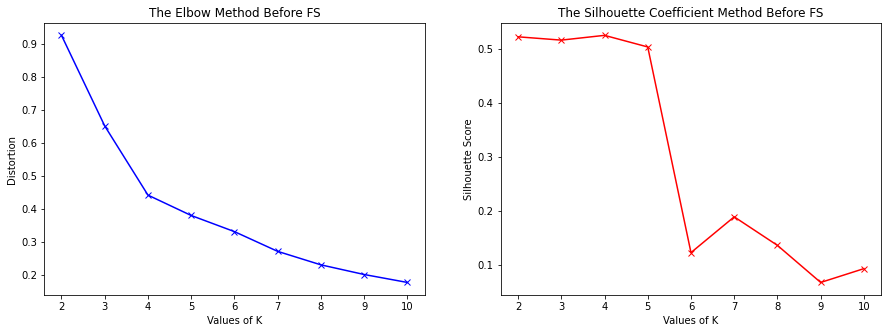

In [119]:
jefferson_grouped_clustering = jefferson_grouped.drop('Zip', 1)

distortions = [] 
silhouette =[]
K = range(2,11) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(jefferson_grouped_clustering)     
    distortions.append(kmeanModel.inertia_)  
    label = kmeanModel.predict(jefferson_grouped_clustering)
    silhouette.append(silhouette_score(jefferson_grouped_clustering, label))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(K, distortions, 'bx-')
ax2.plot(K, silhouette, 'rx-') 
ax1.set_xlabel('Values of K') 
ax1.set_ylabel('Distortion') 
ax2.set_xlabel('Values of K')
ax2.set_ylabel('Silhouette Score')
ax1.set_title('The Elbow Method Before FS') 
ax2.set_title('The Silhouette Coefficient Method Before FS')
plt.show()

There are 77 venue categories in top 10 most common venues


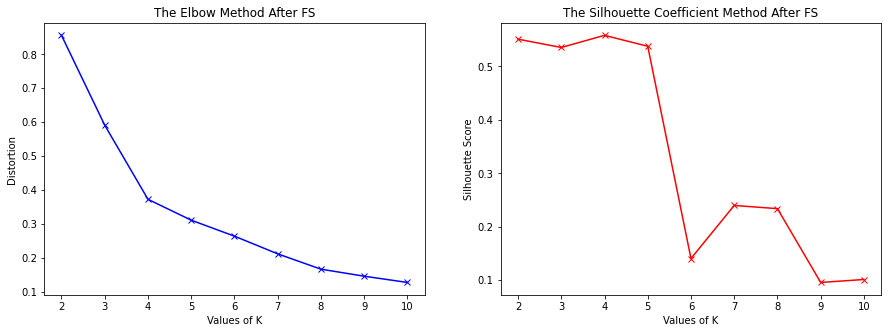

In [120]:
common_list = []

for col in zip_venues_sorted.drop('Zip',axis=1).columns:
    common_list.extend(zip_venues_sorted[col])

common_columns = list(set(common_list))

common_columns
jefferson_grouped_common=jefferson_grouped[common_columns]

print("There are {} venue categories in top 10 most common venues".format(len(common_columns)) )

distortions2 = [] 
silhouette2 =[]
K = range(2,11) 

for k in K: 
    #Building and fitting the model 
    kmeanModel2 = KMeans(n_clusters=k)
    kmeanModel2.fit(jefferson_grouped_common)     
    distortions2.append(kmeanModel2.inertia_)  
    label2 = kmeanModel2.predict(jefferson_grouped_common)
    silhouette2.append(silhouette_score(jefferson_grouped_common, label2))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(K, distortions2, 'bx-')
ax2.plot(K, silhouette2, 'rx-') 
ax1.set_xlabel('Values of K') 
ax1.set_ylabel('Distortion') 
ax2.set_xlabel('Values of K')
ax2.set_ylabel('Silhouette Score')
ax1.set_title('The Elbow Method After FS') 
ax2.set_title('The Silhouette Coefficient Method After FS')
plt.show()


The silhouette coefficient increased a little bit after feature selection. Foursquare API updates its database occasionally. The slightly different venues data returned by Foursquare API gives different silhouette plot. I observed the max value of silhouette coefficient (after feature selection) at k=3 before. Recently when I checked back and run the code again, I observed max silhouette coefficient at k=4. The rule of thumb [5](http://www.ijarcsms.com/docs/paper/volume1/issue6/V1I6-0015.pdf) suggests k=sqrt(29/2)= 3.81. To keep the code consistent, let's choose k =3 for clustering.

#### B. Cluster zip codes

In [121]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jefferson_grouped_common)

zip_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

jefferson_merged = jefferson_gp

# merge jefferson_grouped with jefferson_gp to add latitude/longitude for each zip code
jefferson_merged = jefferson_merged.join(zip_venues_sorted.set_index('Zip'), on='Zip')

jefferson_merged

,Latitude,Longitude,Zip,Primary_city,Irs_estimated_population_2015,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,39.57,-105.14,80127,Littleton,43810,1,Pizza Place,Coffee Shop,Trail,Fast Food Restaurant,Mexican Restaurant,Grocery Store,Bank,Hotel,Brewery,Convenience Store
1,39.62,-105.07,80123,Littleton,42920,1,Grocery Store,Coffee Shop,Pizza Place,Sandwich Place,Golf Course,Asian Restaurant,Mexican Restaurant,Salon / Barbershop,Thrift / Vintage Store,American Restaurant
2,39.56,-105.08,80128,Littleton,35760,1,Coffee Shop,Convenience Store,Italian Restaurant,Pizza Place,Mexican Restaurant,Grocery Store,Sandwich Place,Brewery,Bank,BBQ Joint
3,39.73,-105.21,"80401, 80402",Golden,35209,1,Coffee Shop,Mexican Restaurant,Brewery,Trail,Pizza Place,Park,Sandwich Place,Hotel,Salon / Barbershop,Bar
4,39.82,-105.10,"80001, 80004, 80006",Arvada,35180,1,Coffee Shop,Mexican Restaurant,Pizza Place,Sandwich Place,Bar,Steakhouse,Grocery Store,Bakery,Brewery,Fast Food Restaurant
5,39.83,-105.06,80003,Arvada,33610,1,Mexican Restaurant,Coffee Shop,Pizza Place,Brewery,Steakhouse,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Grocery Store,Sushi Restaurant
6,39.67,-105.09,80227,Denver,32620,1,Mexican Restaurant,Coffee Shop,Pizza Place,Golf Course,Sandwich Place,Ice Cream Shop,Brewery,Italian Restaurant,Bar,Convenience Store
7,39.69,-105.17,80228,Denver,31230,1,Trail,Pizza Place,Coffee Shop,Sandwich Place,Mexican Restaurant,Park,Gym / Fitness Center,Concert Hall,Music Venue,Fast Food Restaurant
8,39.89,-105.11,80021,Broomfield,30350,1,Coffee Shop,Mexican Restaurant,Pizza Place,Hotel,Sandwich Place,Brewery,Furniture / Home Store,Gym / Fitness Center,Restaurant,Burrito Place
9,39.71,-105.09,80226,Denver,29970,1,Sandwich Place,Mexican Restaurant,American Restaurant,Coffee Shop,Cosmetics Shop,Spa,Gym / Fitness Center,Fast Food Restaurant,Thai Restaurant,Ice Cream Shop


#### C. Visualize the resulting clusters

In [122]:
# create map
map_clusters = folium.Map(location=[latitude+0.2, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(0.8*i*i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jefferson_merged['Latitude'], jefferson_merged['Longitude'], jefferson_merged['Zip'], jefferson_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### D. Examine Clusters

#### Cluster 1

In [123]:
jefferson_merged.loc[jefferson_merged['Cluster Labels'] == 0, jefferson_merged.columns[[2] + list(range(5, jefferson_merged.shape[1]))]]

,Zip,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,80403,0,Trail,Mountain,Park,Scenic Lookout,Campground,Public Art,Home Service,Ice Cream Shop,Flower Shop,Fishing Spot
22,80470,0,Mountain,Laundry Service,Business Service,Scenic Lookout,American Restaurant,Discount Store,Financial or Legal Service,Frozen Yogurt Shop,Disc Golf,Food Truck
23,80454,0,Trail,Scenic Lookout,Café,Bar,Coffee Shop,Golf Course,Steakhouse,Park,Other Great Outdoors,Home Service
26,80453,0,Trail,Concert Hall,History Museum,Monument / Landmark,Music Venue,Fishing Spot,Gift Shop,Scenic Lookout,Sandwich Place,Construction & Landscaping


#### Cluster 2

In [124]:
jefferson_merged.loc[jefferson_merged['Cluster Labels'] == 1, jefferson_merged.columns[[2] + list(range(5, jefferson_merged.shape[1]))]]

,Zip,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,80127,1,Pizza Place,Coffee Shop,Trail,Fast Food Restaurant,Mexican Restaurant,Grocery Store,Bank,Hotel,Brewery,Convenience Store
1,80123,1,Grocery Store,Coffee Shop,Pizza Place,Sandwich Place,Golf Course,Asian Restaurant,Mexican Restaurant,Salon / Barbershop,Thrift / Vintage Store,American Restaurant
2,80128,1,Coffee Shop,Convenience Store,Italian Restaurant,Pizza Place,Mexican Restaurant,Grocery Store,Sandwich Place,Brewery,Bank,BBQ Joint
3,"80401, 80402",1,Coffee Shop,Mexican Restaurant,Brewery,Trail,Pizza Place,Park,Sandwich Place,Hotel,Salon / Barbershop,Bar
4,"80001, 80004, 80006",1,Coffee Shop,Mexican Restaurant,Pizza Place,Sandwich Place,Bar,Steakhouse,Grocery Store,Bakery,Brewery,Fast Food Restaurant
5,80003,1,Mexican Restaurant,Coffee Shop,Pizza Place,Brewery,Steakhouse,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Grocery Store,Sushi Restaurant
6,80227,1,Mexican Restaurant,Coffee Shop,Pizza Place,Golf Course,Sandwich Place,Ice Cream Shop,Brewery,Italian Restaurant,Bar,Convenience Store
7,80228,1,Trail,Pizza Place,Coffee Shop,Sandwich Place,Mexican Restaurant,Park,Gym / Fitness Center,Concert Hall,Music Venue,Fast Food Restaurant
8,80021,1,Coffee Shop,Mexican Restaurant,Pizza Place,Hotel,Sandwich Place,Brewery,Furniture / Home Store,Gym / Fitness Center,Restaurant,Burrito Place
9,80226,1,Sandwich Place,Mexican Restaurant,American Restaurant,Coffee Shop,Cosmetics Shop,Spa,Gym / Fitness Center,Fast Food Restaurant,Thai Restaurant,Ice Cream Shop


#### Cluster 3

In [125]:
jefferson_merged.loc[jefferson_merged['Cluster Labels'] == 2, jefferson_merged.columns[[2] + list(range(5, jefferson_merged.shape[1]))]]

,Zip,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,80425,2,Locksmith,Mobile Phone Shop,Trail,Zoo,Fast Food Restaurant,Frozen Yogurt Shop,Food Truck,Food Court,Food,Flower Shop


Let's take a look of the number of 1st Most Common Venue in each cluster.

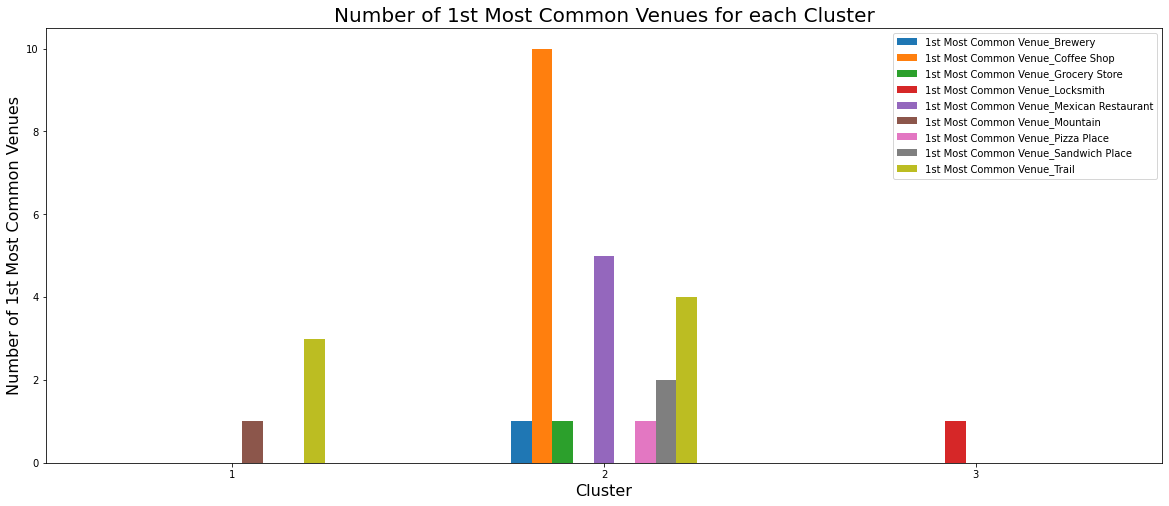

In [126]:
cluster_venues = jefferson_merged[['Zip','Cluster Labels','1st Most Common Venue']]
cluster_onehot = pd.get_dummies(cluster_venues[['1st Most Common Venue']])
cluster_onehot['Zip'] = cluster_venues['Zip'] 
cluster_onehot['Cluster Labels'] = cluster_venues['Cluster Labels']
fixed_columns = list(cluster_onehot.columns[-2:]) + list(cluster_onehot.columns[:-2])
cluster_onehot = cluster_onehot[fixed_columns]

ax =cluster_onehot.groupby('Cluster Labels').sum().plot(kind='bar',figsize=(20,8))

plt.title('Number of 1st Most Common Venues for each Cluster',fontsize=20)
plt.ylabel('Number of 1st Most Common Venues',fontsize=16)
plt.xlabel('Cluster',fontsize=16)
plt.xticks(rotation=0)
ax.set_xticklabels(['1','2','3'])
plt.show()

When we examine the above chart, we can label each cluster:

cluster 1 : leisure mountain area

cluster 2 : lively city/town

cluster 3 : mountain towns

### 7. Analyze Arvada 80007

Now let's review the venues statistical data for Jefferson County and look closely to zip code Arvada,80007. Arvada is a part of the Denver-Aurora-Lakewood, CO Metropolitan Statistical Area [6](https://en.wikipedia.org/wiki/Arvada,_Colorado). My analysis approved that by clustering 80007 in cluster 1. The _jefferson_venues_ data showed 80007 only has 13 venues within the search radius as shown below.

In [127]:
jefferson_venues.groupby('Zip').count()

,Primary_city,Venue,Venue Latitude,Venue Longitude,Venue Category
Zip,,,,,
"80001, 80004, 80006",100,100,100,100,100
80002,100,100,100,100,100
80003,100,100,100,100,100
80005,66,66,66,66,66
80007,17,17,17,17,17
80021,100,100,100,100,100
"80033, 80034",100,100,100,100,100
"80035, 80036",100,100,100,100,100
80123,100,100,100,100,100


Less venues results doesn't necessarily mean the area needs more facilities. A small population may not need as many as services as a large population does. Let's add a new column to give information on how many venues that every 1000 people in the area have.

In [128]:
jefferson_compare = jefferson_venues.groupby('Zip').count()

jefferson_compare = jefferson_compare.join(jefferson_gp[['Irs_estimated_population_2015','Zip']].set_index('Zip'), on='Zip')
jefferson_compare = jefferson_compare[jefferson_compare['Irs_estimated_population_2015'] != 0]
jefferson_compare ['Venue per capita (#/1000)'] = jefferson_compare['Venue']/jefferson_compare['Irs_estimated_population_2015']*1000
jefferson_compare.sort_values(by=['Venue per capita (#/1000)'],inplace=True)
jefferson_compare

,Primary_city,Venue,Venue Latitude,Venue Longitude,Venue Category,Irs_estimated_population_2015,Venue per capita (#/1000)
Zip,,,,,,,
80403,7,7,7,7,7,19020,0.368034
80007,17,17,17,17,17,10950,1.552511
80127,76,76,76,76,76,43810,1.734764
80470,6,6,6,6,6,3290,1.823708
"80437, 80439",46,46,46,46,46,24373,1.887334
80128,75,75,75,75,75,35760,2.097315
80123,100,100,100,100,100,42920,2.329916
80005,66,66,66,66,66,27280,2.419355
"80401, 80402",100,100,100,100,100,35209,2.840183


Let's visualize the data to understand the trend better.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text major ticklabel objects>)

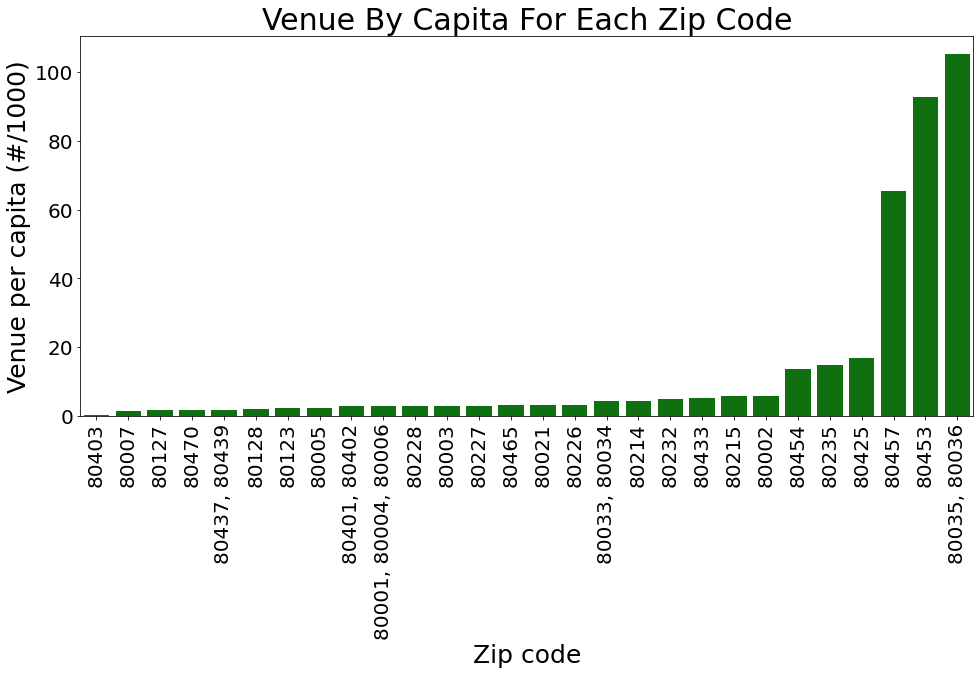

In [129]:
plt.figure(figsize=(16,7))
plt.title("Venue By Capita For Each Zip Code",fontsize = 30)
sns.barplot(x=jefferson_compare.index, y=jefferson_compare['Venue per capita (#/1000)'],color='green')
plt.ylabel("Venue per capita (#/1000)", fontsize=25)
plt.yticks(fontsize=20)
plt.xlabel("Zip code", fontsize=25)
plt.xticks(fontsize=20,rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text major ticklabel objects>)

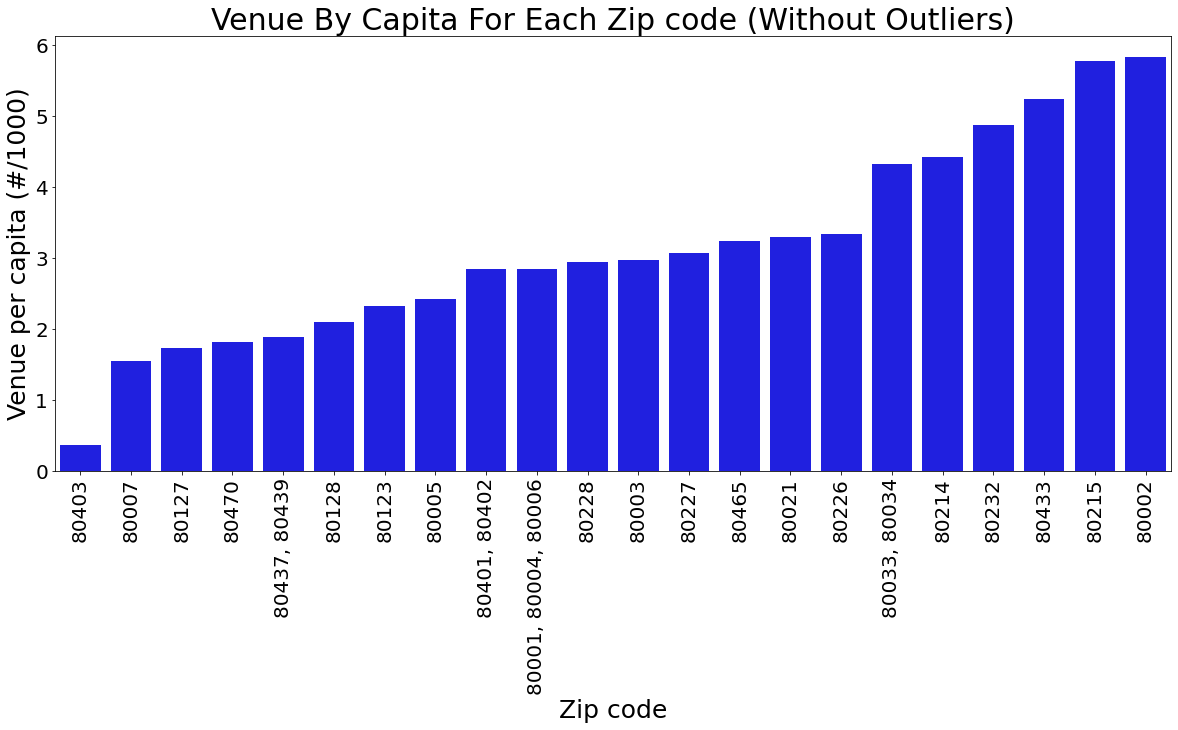

In [130]:
plt.figure(figsize=(20,8))
plt.title("Venue By Capita For Each Zip code (Without Outliers)",fontsize = 30)
sns.barplot(x=jefferson_compare[0:-6].index, y=jefferson_compare[0:-6]['Venue per capita (#/1000)'],color='blue')
plt.ylabel("Venue per capita (#/1000)", fontsize=25)
plt.yticks(fontsize=20)
plt.xlabel("Zip code", fontsize=25)
plt.xticks(fontsize=20,rotation=90)

This figure gives clear demonstration that my zip 80007 is on the lower side when comparing venues per capita to other areas. There are only 13 venues were found within 2.6 miles of center 80007. Let's list the 13 venues below.

In [131]:
venues_80007 = jefferson_venues[jefferson_venues['Zip']== '80007']
venues_80007

,Zip,Primary_city,Venue,Venue Latitude,Venue Longitude,Venue Category
1611,80007,Arvada,King Soopers,39.861430,-105.167493,Grocery Store
1612,80007,Arvada,Jack's Bar & Grill,39.849648,-105.155645,American Restaurant
1613,80007,Arvada,Marco's Pizza,39.849687,-105.155271,Pizza Place
1614,80007,Arvada,Rocky Mountain Foothills,39.864903,-105.238088,Scenic Lookout
1615,80007,Arvada,Starbucks,39.856859,-105.164997,Coffee Shop
1616,80007,Arvada,Steamers Coffee House,39.849658,-105.155603,Coffee Shop
1617,80007,Arvada,7-Eleven,39.856619,-105.164946,Convenience Store
1618,80007,Arvada,Cold War Horse,39.858636,-105.194369,Outdoor Sculpture
1619,80007,Arvada,Dina's Enterprises,39.854520,-105.192870,Boutique
1620,80007,Arvada,Lookout Park,39.849501,-105.196848,Park


Among those 13 venues, there are only 2 sit-down restaurant and 1 brewery. There is no fast food restaurant found within the area to offset the lack of the nearby food establishments. People have to visit grocery store deli department for a quick grab-and-go meal. 

### 8. Arvada in Jefferson County

Now Let's take a closer look at city of Arvada

In [132]:
jefferson_no_outliers = jefferson_compare[0:-6]
arvada_compare = jefferson_venues[jefferson_venues['Primary_city']=='Arvada'].groupby('Zip').count()

#arvada_city = jefferson_no_outliers.loc[arvada_compare.index]
#other_city = jefferson_no_outliers.loc[set(jefferson_no_outliers.index)-set(arvada_compare.index)]
#arvada_city

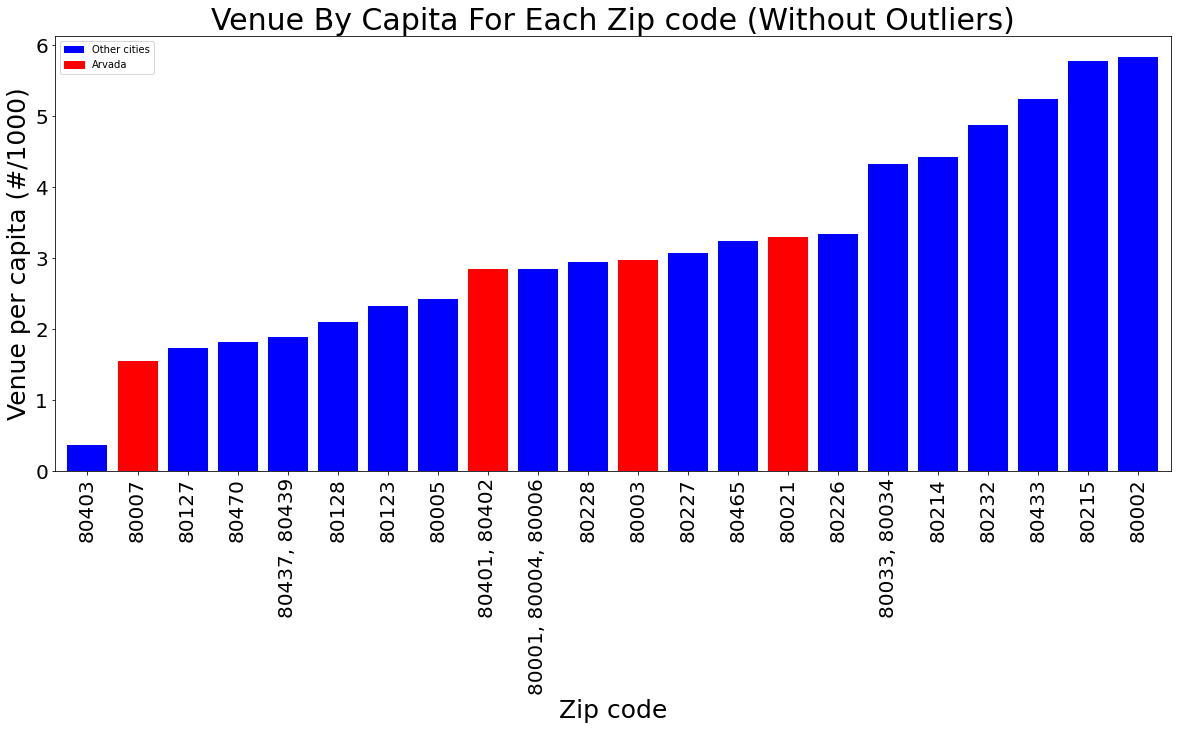

In [133]:
color = []
for zipcode in jefferson_no_outliers.index:
    if zipcode in set(arvada_compare.index): color.append('red') 
    color.append('blue')



ax = jefferson_no_outliers.reset_index().plot(kind = 'bar',
                                              y='Venue per capita (#/1000)',
                                              figsize=(20,8),
                                              width=0.8,
                                              color = color,
                                              label='Other cities')


ax.set_title('Venue By Capita For Each Zip code (Without Outliers)',fontsize=30)
ax.set_xlabel("Zip code", fontsize=25)
ax.set_ylabel("Venue per capita (#/1000)", fontsize=25)
ax.set_xticklabels(jefferson_no_outliers.index.tolist())
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)


handles, labels = ax.get_legend_handles_labels()
patch = mpatches.Patch(color='Red', label='Arvada')
handles.append(patch) 
plt.legend(handles=handles, loc='upper left')



It is obvious that all zip codes in city of Arvada have relatively low to medium venue per capita value comparing to other areas in Jefferson county. Zip code 80007 has the lowest venues per capita in all Arvada zip codes. I think we do need more venues in our 80007 neighborhoods.

### 9. Venues in Arvada

In [134]:
Arvada_venues = jefferson_venues[jefferson_venues['Primary_city']== 'Arvada']
Arvada_venues.reset_index(inplace=True)
Arvada_venues.drop(columns=['index'],inplace=True)
Arvada_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Zip,Primary_city,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"80001, 80004, 80006",Arvada,Majestic View Park,39.824787,-105.099206,Park
1,"80001, 80004, 80006",Arvada,Arvada Center For The Arts And Humanities,39.823260,-105.083718,Performing Arts Venue
2,"80001, 80004, 80006",Arvada,Taunaz Tavern,39.812216,-105.115348,Bar
3,"80001, 80004, 80006",Arvada,"Colorado Coins, Cards & Comics",39.818059,-105.081914,Bookstore
4,"80001, 80004, 80006",Arvada,Johnny Roberts Memorial Disc Golf Course,39.804300,-105.085913,Disc Golf
...,...,...,...,...,...,...
378,80007,Arvada,Standley Lake Stables,39.867446,-105.163480,Stables
379,80007,Arvada,Century Communities,39.869151,-105.223845,Construction & Landscaping
380,80007,Arvada,Pioneer Sand Company - Landscape Supply Materials,39.838051,-105.214066,Garden Center
381,80007,Arvada,Stoney Creek,39.871199,-105.155176,Golf Course


To analyze venues in Arvada, specifically food venues in Arvada, let's create a list that contains all the food venue categories. First I will scrape all venues list from Foursquare venue categories [7](https://developer.foursquare.com/docs/build-with-foursquare/categories/). Then I will use the beaufifulsoup library [8](https://medium.com/datadriveninvestor/using-beautifulsoup-in-python-to-scrape-a-list-of-44-best-bars-in-the-twin-cities-5a04af3a5d8c) to scrape the list from Foursquare venue categories page.

In [135]:
url = 'https://developer.foursquare.com/docs/build-with-foursquare/categories/'
data = requests.get(url)
soup = BeautifulSoup(data.text, 'html.parser')
venues_soup = soup.find("div")
food_soup=venues_soup.find("h3",string='Food')
food_list_h3=food_soup.next_sibling.next_sibling.find_all('h3')
food_list=[]
for line in food_list_h3:
    food_list.append(line.string)
food_list

['Afghan Restaurant',
 'African Restaurant',
 'Ethiopian Restaurant',
 'American Restaurant',
 'New American Restaurant',
 'Asian Restaurant',
 'Burmese Restaurant',
 'Cambodian Restaurant',
 'Chinese Restaurant',
 'Anhui Restaurant',
 'Beijing Restaurant',
 'Cantonese Restaurant',
 'Cha Chaan Teng',
 'Chinese Aristocrat Restaurant',
 'Chinese Breakfast Place',
 'Dim Sum Restaurant',
 'Dongbei Restaurant',
 'Fujian Restaurant',
 'Guizhou Restaurant',
 'Hainan Restaurant',
 'Hakka Restaurant',
 'Henan Restaurant',
 'Hong Kong Restaurant',
 'Huaiyang Restaurant',
 'Hubei Restaurant',
 'Hunan Restaurant',
 'Imperial Restaurant',
 'Jiangsu Restaurant',
 'Jiangxi Restaurant',
 'Macanese Restaurant',
 'Manchu Restaurant',
 'Peking Duck Restaurant',
 'Shaanxi Restaurant',
 'Shandong Restaurant',
 'Shanghai Restaurant',
 'Shanxi Restaurant',
 'Szechuan Restaurant',
 'Taiwanese Restaurant',
 'Tianjin Restaurant',
 'Xinjiang Restaurant',
 'Yunnan Restaurant',
 'Zhejiang Restaurant',
 'Filipino R

In [136]:
Arvada_venues['Food'] = Arvada_venues.apply(lambda row:row['Venue Category'] in food_list,axis=1)

Arvada_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Zip,Primary_city,Venue,Venue Latitude,Venue Longitude,Venue Category,Food
0,"80001, 80004, 80006",Arvada,Majestic View Park,39.824787,-105.099206,Park,False
1,"80001, 80004, 80006",Arvada,Arvada Center For The Arts And Humanities,39.823260,-105.083718,Performing Arts Venue,False
2,"80001, 80004, 80006",Arvada,Taunaz Tavern,39.812216,-105.115348,Bar,False
3,"80001, 80004, 80006",Arvada,"Colorado Coins, Cards & Comics",39.818059,-105.081914,Bookstore,False
4,"80001, 80004, 80006",Arvada,Johnny Roberts Memorial Disc Golf Course,39.804300,-105.085913,Disc Golf,False
...,...,...,...,...,...,...,...
378,80007,Arvada,Standley Lake Stables,39.867446,-105.163480,Stables,False
379,80007,Arvada,Century Communities,39.869151,-105.223845,Construction & Landscaping,False
380,80007,Arvada,Pioneer Sand Company - Landscape Supply Materials,39.838051,-105.214066,Garden Center,False
381,80007,Arvada,Stoney Creek,39.871199,-105.155176,Golf Course,False


In [137]:
Arvada_food = Arvada_venues.groupby('Zip').count()
#Arvada_venues['Food'].value_counts()
Arvada_food['Food'] = Arvada_venues.groupby('Zip').sum()['Food']
Arvada_food

,Primary_city,Venue,Venue Latitude,Venue Longitude,Venue Category,Food
Zip,,,,,,
"80001, 80004, 80006",100,100,100,100,100,60.0
80002,100,100,100,100,100,58.0
80003,100,100,100,100,100,60.0
80005,66,66,66,66,66,35.0
80007,17,17,17,17,17,4.0


Let's plot the total venues and food venues for each zip code in Arvada. 

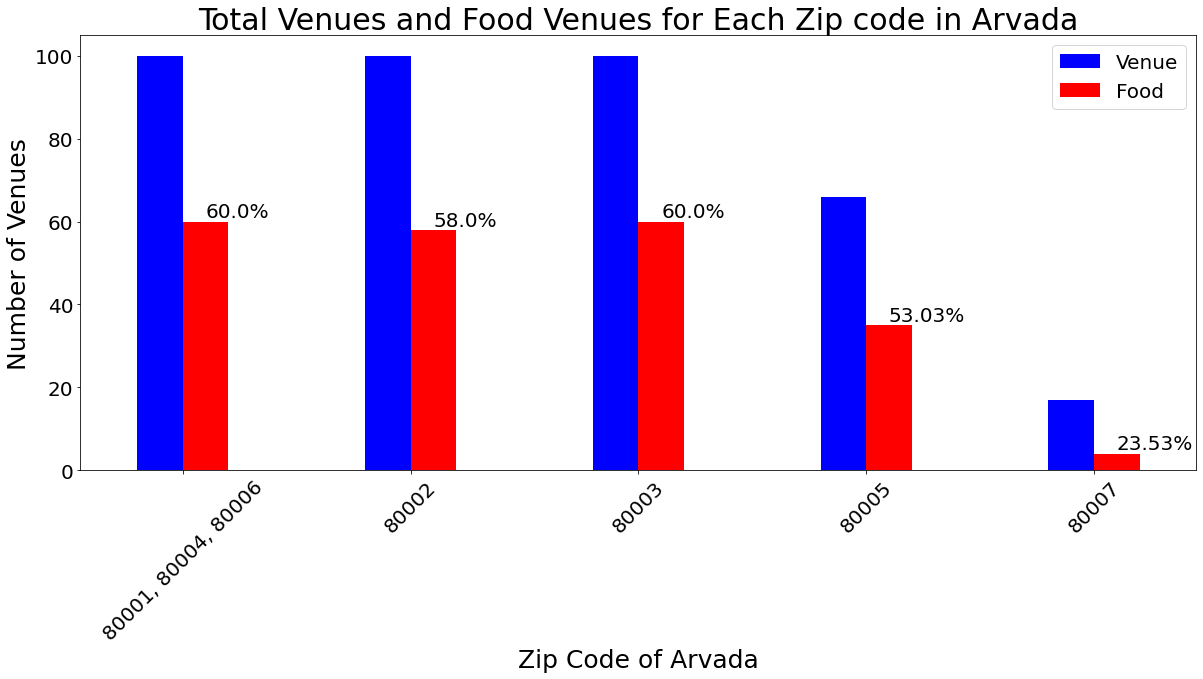

In [138]:
ax = Arvada_food.plot(kind = 'bar',
                      y = ['Venue','Food'],
                      figsize=(20,8),
                      width=0.4,
                      color =['blue','red'])

for i, label in enumerate(list(Arvada_food.index)):
    ratio = round(Arvada_food.loc[label]['Food']/Arvada_food.loc[label]['Venue']*100,2)
    ax.annotate(str(ratio)+'%', (i+0.1, Arvada_food.loc[label]['Food'] + 1),ha='left',fontsize=20)
ax.set_title('Total Venues and Food Venues for Each Zip code in Arvada',fontsize=30)
ax.set_xlabel("Zip Code of Arvada", fontsize=25)
ax.set_ylabel("Number of Venues", fontsize=25)
ax.set_xticklabels(Arvada_food.index.tolist(),rotation=45)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.legend(fontsize=20)


Other zip codes show more than 50% of total venues are food venues. Zip 80007 has not only a lot less total venues than other Arvada zip codes, but also less food venues ratio in total total venues. Now I can totally understand the reason why there were so many complaints from my neighbors.

### Conclusion

Our neighborhood is developing very fast. Currently more than 10 projects are being under construction in 80007 neighborhood and most of them are residential projects [9](https://arvada.maps.arcgis.com/apps/Shortlist/index.html?appid=a985f06bc52943f7a6d61be283d33f2e) . The nearby services and facilities need keep pace with the rapid growth of our city. Food is one of the basic necessities of humans, and it stands first among all basic needs – food, shelter, and clothing. Hope there will be more varieties of food places to improve the quality of life for my neighbors. 